In [ ]:
!pip install kaggle
from google.colab import files
!mkdir '/root/.kaggle'
hasil = files.upload()
nama_file = f'"./{next(iter(hasil))}"'

!mv $nama_file '/root/.kaggle/kaggle.json'
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/drive-digital-retinal-images-for-vessel-extraction
!unzip drive-digital-retinal-images-for-vessel-extraction.zip


Bagian ini berfungsi untuk mengecek adanya GPU yang membantu proses training

In [ ]:
!nvidia-smi

Wed Jun 21 23:40:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060         Off| 00000000:2B:00.0  On |                  N/A |
| 30%   48C    P5               12W / 170W|    716MiB / 12288MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Import beberapa libtrary yang diperlukan

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import cv2
import pandas as pd


Kita akan menggunakan beberapa metriks, seperti precision, recall, f1 score, accuracy, dan Jaccard Index. Fungsi ini didefinisikan secara manual karena beberapa metriks dari Tensorflow tidak mensupport metriks saat jumlah kelas lebih dari dua.

In [ ]:
#Calculate precision from predict[:,:,1] and true mask
def precision(pred,true):
    pred = np.where(pred>0.5,1,0)
    #True positive
    tp = np.sum((pred==1) & (true==1))
    #False positive
    fp = np.sum((pred==1) & (true==0))
    return tp/(tp+fp)

#Calculate recall from predict[:,:,1] and true mask
def recall(pred,true):
    pred = np.where(pred>0.5,1,0)
    #True positive
    tp = np.sum((pred==1) & (true==1))
    #False negative
    fn = np.sum((pred==0) & (true==1))
    return tp/(tp+fn)

#Calculate f1 score from predict[:,:,1] and true mask
def f1_score(pred,true):
    return 2 * (precision(pred,true) * recall(pred,true)) / (precision(pred,true) + recall(pred,true))

def accuracy(pred,true):
    pred = np.where(pred>0.5,1,0)
    return np.sum(pred==true) / np.prod(true.shape)

def jaccard(pred,true):
    pred = np.where(pred>0.5,1,0)
    intersection = np.sum((pred==1) & (true==1))
    union = np.sum((pred==1) | (true==1))
    return intersection/union

Kita mengeset tipe data dengan FP16 untuk mengurangi beban memori dan mengeset seed untuk *reproducibility*

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
tf.keras.utils.set_random_seed(456368)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


Bagian ini digunakan untuk mengambil dataset

In [ ]:

#example of item : './Data/training/images/21_training.tif'
training_index = [item.split("_")[0] for item in os.listdir("./Data/training/images")]

training_images = [f"./DRIVE/training/images/{idx}_training.tif" for idx in training_index]
training_manuals= [f"./DRIVE/training/1st_manual/{idx}_manual1.gif" for idx in training_index]
training_masks= [f"./DRIVE/training/mask/{idx}_training_mask.gif" for idx in training_index]

test_index = [item.split("_")[0] for item in os.listdir("./Data/test/images")]

test_images = [f"./DRIVE/test/images/{idx}_test.tif" for idx in test_index]
test_manuals= [f"./DRIVE/test/1st_manual/{idx}_manual1.gif" for idx in test_index]
test_masks= [f"./DRIVE/test/mask/{idx}_test_mask.gif" for idx in test_index]

Bagian ini digunakan untuk augmentasi data dengan secara random melakukan scaling, rotation, dan flipping.

In [ ]:
def augment_dataset(training_images_path,training_manuals_path,training_masks_path,output_path,multiplicator=10):
    #random scale, random rotation, random flip
    for i in range(len(training_images_path)):
        image = Image.open(training_images_path[i])
        manual = Image.open(training_manuals_path[i])
        mask = Image.open(training_masks_path[i])
        for j in range(multiplicator):
            #random scale
            scale = random.uniform(0.9,1.1)
            image = image.resize((int(image.size[0]*scale),int(image.size[1]*scale)))
            manual = manual.resize((int(manual.size[0]*scale),int(manual.size[1]*scale)))
            mask = mask.resize((int(mask.size[0]*scale),int(mask.size[1]*scale)))
            #random rotation
            angle = random.uniform(-10,10)
            image = image.rotate(angle)
            manual = manual.rotate(angle)
            mask = mask.rotate(angle)
            #random flip
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                manual = manual.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            os.makedirs(f"{output_path}/images",exist_ok=True)
            os.makedirs(f"{output_path}/manuals",exist_ok=True)
            os.makedirs(f"{output_path}/masks",exist_ok=True)
            image.save(f"{output_path}/images/{i}_{j}.png")
            manual.save(f"{output_path}/manuals/{i}_{j}.png")
            mask.save(f"{output_path}/masks/{i}_{j}.png")

augment_dataset(training_images,training_manuals,training_masks,"./Data/augmented",multiplicator=10)
training_images += [f"./Data/augmented/images/{item}" for item in os.listdir("./Data/augmented/images")]
training_manuals += [f"./Data/augmented/manuals/{item}" for item in os.listdir("./Data/augmented/manuals")]
training_masks += [f"./Data/augmented/masks/{item}" for item in os.listdir("./Data/augmented/masks")]

Bagian ini merupakan contoh channel-channel yang menjadi input skenario.

(-0.5, 564.5, 583.5, -0.5)

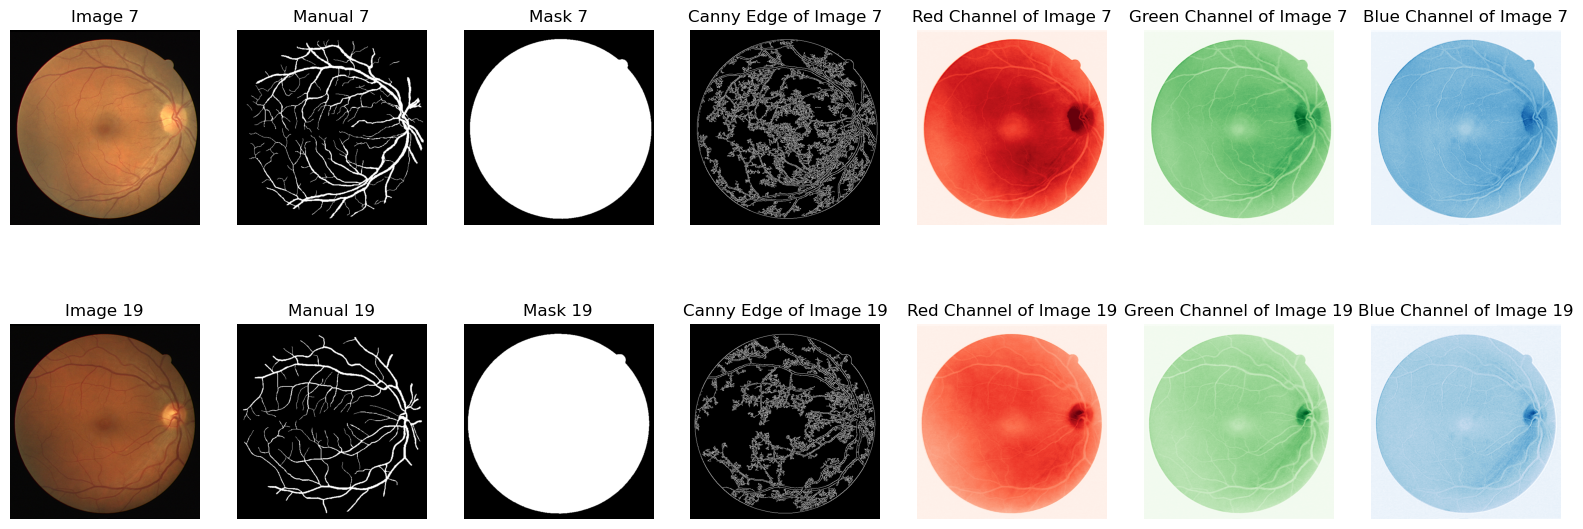

In [ ]:
num_example = 2
sample_idxs = random.sample(range(len(training_index)),num_example)
fig, ax = plt.subplots(num_example,7,figsize=(20,7))

i=0
for idx in sample_idxs:
  training_img = Image.open(training_images[idx])
  ax[i,0].imshow(training_img)
  ax[i,0].axis('off')
  ax[i,0].set_title(f"Image {idx}")

  training_mnl = Image.open(training_manuals[idx])
  ax[i,1].imshow(training_mnl,cmap='gray')
  ax[i,1].axis('off')
  ax[i,1].set_title(f"Manual {idx}")

  training_msk = Image.open(training_masks[idx])
  ax[i,2].imshow(training_msk,cmap='gray')
  ax[i,2].axis('off')
  ax[i,2].set_title(f"Mask {idx}")

  # Canny Edge Detection from Input Image
  img = cv2.imread(training_images[idx],0)
  edges = cv2.Canny(img,0,75)
  ax[i,3].imshow(Image.fromarray(edges),cmap='gray')
  ax[i,3].axis('off')
  ax[i,3].set_title(f"Canny Edge of Image {idx}")

  # Red Channel of Input Image
  ax[i,4].imshow(Image.fromarray(np.array(training_img)[:,:,0]),cmap='Reds')
  ax[i,4].axis('off')
  ax[i,4].set_title(f"Red Channel of Image {idx}")

  # Green Channel of Input Image
  ax[i,5].imshow(Image.fromarray(np.array(training_img)[:,:,1]),cmap='Greens')
  ax[i,5].axis('off')
  ax[i,5].set_title(f"Green Channel of Image {idx}")

  # Blue Channel of Input Image
  ax[i,6].imshow(Image.fromarray(np.array(training_img)[:,:,2]),cmap='Blues')
  ax[i,6].axis('off')
  ax[i,6].set_title(f"Blue Channel of Image {idx}")

  i+=1

plt.axis('off')

Bagian ini menunjukkan definisi kelas dataset yang akan ditrain.

In [ ]:
#create data generator classes for training

class Retina(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list

    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])


        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.



        return batch_x,batch_y

In [ ]:
np.array(Image.open("./Data/training/images/21_training.tif")).shape

(584, 565, 3)

# Unet Architecture

![](https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

Kita pertama-tama mendefinisikan blok-blok contracting layer dan expansive layer. Lalu, kita menyusun arsitektur U-Net keseluruhan dengan mengkombinasikan blok-blok tadi sehingga tampak seperti huruf U.

In [ ]:
def contraction_layers(inputs, num_filters, dropout_rate=0.2, kernel_size=(3,3), padding='same', activation='relu', pool=True):
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding, activation=activation, kernel_initializer='he_normal')(inputs)
    conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding, activation=activation, kernel_initializer='he_normal')(conv)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    relu = tf.keras.layers.ReLU()(batch_norm)
    if pool:
        pool = tf.keras.layers.MaxPooling2D((2,2))(relu)
        return pool, relu
    else:
        return relu

def expansive_layers(inputs, num_filters, skip_features, dropout_rate=0.2, kernel_size=(3,3), padding='same', activation='relu'):
    conv = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size, strides=(2,2), padding=padding)(inputs)
    concat = tf.keras.layers.Concatenate()([conv, skip_features])
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding, activation=activation)(concat)
    conv = tf.keras.layers.Dropout(dropout_rate)(conv)
    conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding, activation=activation)(conv)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    relu = tf.keras.layers.ReLU()(batch_norm)
    return relu

def make_unet(image_size, num_classes, input_channels=3,F=32):
    inputs = tf.keras.layers.Input(image_size + (input_channels,))


    #Contraction path
    num_filters_contractions = [F*2**i for i in range(5)]

    p1, c1 = contraction_layers(inputs, num_filters_contractions[0], kernel_size=(3,3), padding='same', activation='relu', pool=True)
    p2, c2 = contraction_layers(p1, num_filters_contractions[1], kernel_size=(3,3), padding='same', activation='relu', pool=True)
    p3, c3 = contraction_layers(p2, num_filters_contractions[2], kernel_size=(3,3), padding='same', activation='relu', pool=True)
    p4, c4 = contraction_layers(p3, num_filters_contractions[3], kernel_size=(3,3), padding='same', activation='relu', pool=True)

    c5 = tf.keras.layers.Conv2D(num_filters_contractions[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(num_filters_contractions[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = expansive_layers(c5, num_filters_contractions[-2], c4, dropout_rate=0.2, kernel_size=(3,3), padding='same', activation='relu')
    u7 = expansive_layers(u6, num_filters_contractions[-3], c3, dropout_rate=0.2, kernel_size=(3,3), padding='same', activation='relu')
    u8 = expansive_layers(u7, num_filters_contractions[-4], c2, dropout_rate=0.1, kernel_size=(3,3), padding='same', activation='relu')
    u9 = expansive_layers(u8, num_filters_contractions[-5], c1, dropout_rate=0.1, kernel_size=(3,3), padding='same', activation='relu')

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes==1 else 'softmax')(u9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()


Lalu, kita bisa menyusun model yang kita definisikan sebelumnya.

In [ ]:
img_size = (128, 128)
batch_size = 1
# Build model
num_classes = 3
model = make_unet(img_size, num_classes, input_channels=3,F=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

Kode ini digunakan untuk membuat data generator dari dataset.

In [ ]:
train_gen = Retina(batch_size,img_size,training_images,training_masks,training_manuals)
test_gen = Retina(batch_size,img_size,test_images,test_masks,test_manuals)

In [ ]:
next(train_gen.__iter__())[0].shape

(1, 128, 128, 3)

Lalu kita mengeset optimizer dengan Adam dan Loss dengan Cross Entropy (Binary jika hanya ada dua kelas, Categorical jika ada lebih dari dua kelas).

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
losses = tf.keras.losses.BinaryCrossentropy() if num_classes==1 else tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=losses,metrics=[ 'accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)


Kode ini digunakan untuk melakukan training.

In [ ]:
epochs = 40
history = model.fit(train_gen,epochs=epochs,validation_data=test_gen, callbacks=[callback])

Epoch 1/40
220/220 [==============================] - 10s 14ms/step - loss: 0.5139 - accuracy: 0.7122 - val_loss: 0.9062 - val_accuracy: 0.6051
Epoch 2/40
220/220 [==============================] - 3s 13ms/step - loss: 0.2043 - accuracy: 0.8286 - val_loss: 0.9209 - val_accuracy: 0.6183
Epoch 3/40
220/220 [==============================] - 3s 13ms/step - loss: 0.1754 - accuracy: 0.8303 - val_loss: 0.8759 - val_accuracy: 0.7185
Epoch 4/40
220/220 [==============================] - 3s 13ms/step - loss: 0.1584 - accuracy: 0.8310 - val_loss: 0.7522 - val_accuracy: 0.8559
Epoch 5/40
220/220 [==============================] - 3s 13ms/step - loss: 0.1464 - accuracy: 0.8314 - val_loss: 0.6727 - val_accuracy: 0.8865
Epoch 6/40
220/220 [==============================] - 3s 13ms/step - loss: 0.1373 - accuracy: 0.8320 - val_loss: 0.6059 - val_accuracy: 0.8914
Epoch 7/40
220/220 [==============================] - 3s 13ms/step - loss: 0.1300 - accuracy: 0.8328 - val_loss: 0.5021 - val_accuracy: 0.898

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Kita bisa melihat plot grafik dari training yang kita lakukan.

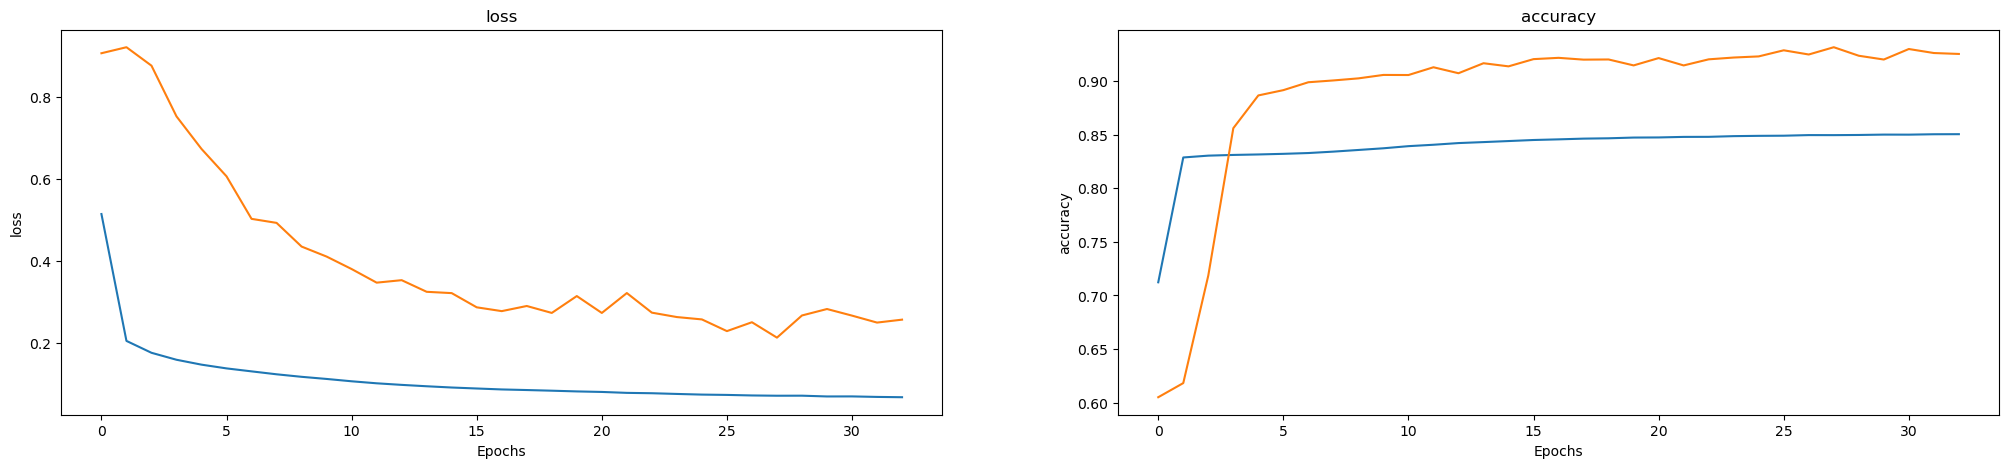

In [ ]:
fig, ax = plt.subplots(1,len(history.history.keys())//2,figsize=(25,5))
for i, key in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[key])
    ax[i].plot(history.history['val_'+key])
    ax[i].set_title(key)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(key)


plt.show()

Ini adalah kode untuk menunjukkan prediksi ke salah satu citra.

In [ ]:
def preprocess_for_prediction(img):
  img = np.array(Image.open(img).resize(img_size,resample=Image.Resampling.NEAREST))
  img = img/255.
  return img

def predict_image(img):
  img = preprocess_for_prediction(img)
  img = np.expand_dims(img,axis=0)
  pred = model.predict(img)
  pred = np.squeeze(pred,axis=0)
  #Convert probabilities to binary output
  #pred = np.where(pred>0.5,1,0)
  return pred

1/1 [==============================] - 0s 10ms/step


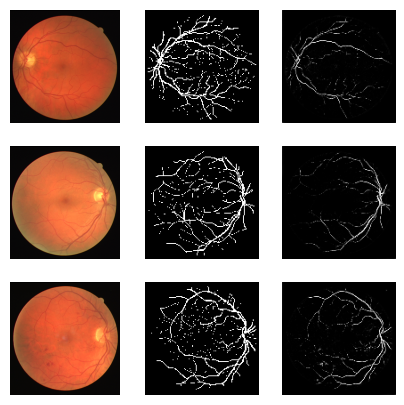

In [ ]:


#compare true image manuals and predicted masks in matplotlib plots
num_example = 3
sample_idxs = random.sample(range(len(test_index)),num_example)
fig, ax = plt.subplots(num_example,3,figsize=(5,5))

for i,idx in enumerate(sample_idxs):
    test_img = Image.open(test_images[idx])
    ax[i,0].imshow(test_img)
    ax[i,0].axis('off')

    test_mnl = Image.open(test_manuals[idx])
    ax[i,1].imshow(preprocess_for_prediction(test_manuals[idx]),cmap='gray')
    ax[i,1].axis('off')

    pred = predict_image(test_images[idx])
    ax[i,2].imshow(pred[:,:,1],cmap='gray')
    ax[i,2].axis('off')







## Case Per Case Comparison

Selanjutnya, untuk masing-masing skenario, kita harus mendefinisikan manual cara membaca file gambar agar bisa menjadi input dari model.

In [ ]:
class RetinaRGB(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list

    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])


        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y

class RetinaRed(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list

    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])[:,:,:,0]
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])


        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y

class RetinaGreen(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list

    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])[:,:,:,1]
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])


        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y

class RetinaBlue(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list

    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]


        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])[:,:,:,2]
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])


        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y

class RetinaGrayScale(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list


    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST).convert('L')) for fname in batch_x])
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])

        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y

class RetinaCanny(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list


    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = np.array([cv2.resize(cv2.Canny(cv2.imread(fname,0),0,75),self.image_size) for fname in batch_x])
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])

        batch_x = batch_x/255.
        batch_y = batch_y/255.

        batch_x = np.expand_dims(batch_x,axis=-1)

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.


        return batch_x,batch_y

class GrayscalePlusCanny(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list


    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x_gray = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST).convert('L')) for fname in batch_x])
        batch_x_canny = np.array([cv2.resize(cv2.Canny(cv2.imread(fname,0),0,75),self.image_size) for fname in batch_x])
        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.
        batch_y = batch_y/255.
        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.


        batch_x = np.stack([batch_x_gray,batch_x_canny],axis=-1) / 255.

        return batch_x,batch_y

class RGBPlusCanny(tf.keras.utils.Sequence):
    def __init__(self,batch_size,image_size,img_list,mask_list,manual_list):
        self.batch_size = batch_size
        self.image_size = image_size
        self.img_list = img_list
        self.mask_list = mask_list
        self.manual_list = manual_list


    def __len__(self):
        return len(self.img_list)//self.batch_size

    def __getitem__(self,idx):
        batch_x = self.img_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.manual_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x_rgb = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_x])
        batch_x_canny = np.array([cv2.resize(cv2.Canny(cv2.imread(fname,0),0,75),self.image_size) for fname in batch_x])
        #Menambahkan dimensi channel dari canny edge yang hanya memiliki 1 layer
        batch_x_canny = np.expand_dims(batch_x_canny,axis=-1)

        batch_y = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_y])

        batch_x = np.concatenate([batch_x_rgb,batch_x_canny],axis=-1) / 255.
        batch_y = batch_y/255.

        batch_mask = self.mask_list[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask = np.array([np.array(Image.open(fname).resize(self.image_size,resample=Image.Resampling.NEAREST)) for fname in batch_mask])
        batch_mask = batch_mask/255.

        #If mask is 0, then manual become class 2 (background)
        batch_y[batch_mask==0.] = 2.

        return batch_x,batch_y


Lalu, kita menyusun list skenario yang ingin kita uji.

In [ ]:
list_case =[
    {
        "input": "Grayscale",
        "input_channels": 1,
        "class_name": RetinaGrayScale
    },
    {
        "input": "Red",
        "input_channels": 1,
        "class_name": RetinaRed
    },
    {
        "input": "Green",
        "input_channels": 1,
        "class_name": RetinaGreen
    },
    {
        "input": "Blue",
        "input_channels": 1,
        "class_name": RetinaBlue
    },
    {
        "input": "RGB",
        "input_channels": 3,
        "class_name": RetinaRGB
    },
    {
        "input": "Canny",
        "input_channels": 1,
        "class_name": RetinaCanny
    },
    {
        "input": "Grayscale + Canny",
        "input_channels": 2,
        "class_name": GrayscalePlusCanny
    },
    {
        "input": "RGB + Canny",
        "input_channels": 4,
        "class_name": RGBPlusCanny
    },
]


Untuk setiap kasus, kita melakukan training dahulu, lalu modelnya kita simpan dalam bentuk file..

In [ ]:
epochs = 40
num_classes = 3
img_size = (128, 128)
batch_size = 1

In [ ]:
history_dict_list = []
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0002, restore_best_weights=True)
for case in list_case:
    print(f"Training with {case['input']} input")
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(1e-4)
    losses = tf.keras.losses.BinaryCrossentropy() if num_classes==1 else tf.keras.losses.SparseCategoricalCrossentropy()
    model = make_unet(img_size, num_classes, input_channels=case['input_channels'])
    model.compile(optimizer=optimizer,loss=losses,metrics=[ 'accuracy'])
    train_gen = case['class_name'](batch_size,img_size,training_images,training_masks,training_manuals)
    test_gen = case['class_name'](batch_size,img_size,test_images,test_masks,test_manuals)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
    history = model.fit(train_gen,epochs=epochs,validation_data=test_gen, callbacks=[callback])
    history_dict_list.append({**case, "history": history.history, "total_params":model.count_params()})
    #save model
    model.save(f"./{case['input']}.h5")


Training with Grayscale input
Epoch 1/40
220/220 [==============================] - 10s 16ms/step - loss: 0.3885 - accuracy: 0.7596 - val_loss: 0.9815 - val_accuracy: 0.6014
Epoch 2/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1866 - accuracy: 0.8292 - val_loss: 0.9402 - val_accuracy: 0.6388
Epoch 3/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1627 - accuracy: 0.8307 - val_loss: 0.7514 - val_accuracy: 0.8108
Epoch 4/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1499 - accuracy: 0.8310 - val_loss: 0.6103 - val_accuracy: 0.8671
Epoch 5/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1395 - accuracy: 0.8317 - val_loss: 0.5038 - val_accuracy: 0.8941
Epoch 6/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1310 - accuracy: 0.8325 - val_loss: 0.4579 - val_accuracy: 0.8977
Epoch 7/40
220/220 [==============================] - 3s 15ms/step - loss: 0.1225 - accuracy: 0.8344 - val_loss

Lalu, kita bisa membandingkan model yang kita buat dan juga proses trainingnya.

In [ ]:
pd_history = pd.DataFrame(columns=['input','total_params','loss','val_loss','accuracy','val_accuracy'])
for history_dict in history_dict_list:
    pd_history = pd.concat(
        [
            pd_history,
            pd.DataFrame(
                [{
                    'input': history_dict['input'],
                    'total_params': history_dict['total_params'],
                    'loss': history_dict['history']['loss'][-1],
                    'val_loss': history_dict['history']['val_loss'][-1],
                    'accuracy': history_dict['history']['accuracy'][-1],
                    'val_accuracy': history_dict['history']['val_accuracy'][-1],
                }],
            )
        ]
    )
pd_history = pd_history.reset_index(drop=True)
pd_history

,input,total_params,loss,val_loss,accuracy,val_accuracy
0,Grayscale,8635875,0.079597,0.326288,0.846819,0.911804
1,Red,8635875,0.081463,0.261090,0.845461,0.922351
2,Green,8635875,0.067785,0.308295,0.850109,0.920230
3,Blue,8635875,0.082760,0.267328,0.844864,0.918945
4,RGB,8636451,0.071945,0.248407,0.848842,0.922400
5,Canny,8635875,0.122711,0.273706,0.831626,0.904639
6,Grayscale + Canny,8636163,0.083934,0.273859,0.844037,0.913992
7,RGB + Canny,8636739,0.062909,0.246381,0.851026,0.927579


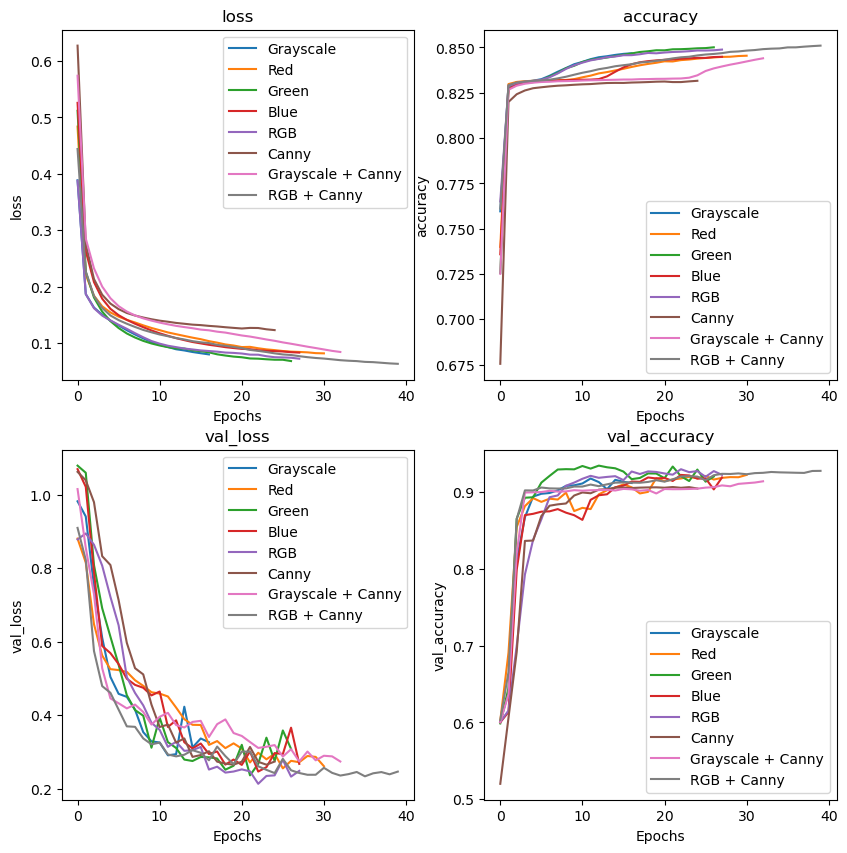

In [ ]:
list_of_metrics = ['loss','accuracy','val_loss','val_accuracy']
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i, metric in enumerate(list_of_metrics):

    for history_dict in history_dict_list:
        ax[i//2,i%2].plot(history_dict['history'][metric])
        ax[i//2,i%2].set_title(metric)
        ax[i//2,i%2].set_xlabel('Epochs')
        ax[i//2,i%2].set_ylabel(metric)
        ax[i//2,i%2].legend([history_dict['input'] for history_dict in history_dict_list])


1/1 [==============================] - 0s 197ms/step
(20, 128, 128)
1/1 [==============================] - 0s 194ms/step
(20, 128, 128)
1/1 [==============================] - 0s 190ms/step
(20, 128, 128)
1/1 [==============================] - 0s 196ms/step
(20, 128, 128)
1/1 [==============================] - 0s 194ms/step
(20, 128, 128)
1/1 [==============================] - 0s 187ms/step
(20, 128, 128)
1/1 [==============================] - 0s 185ms/step
(20, 128, 128)
1/1 [==============================] - 0s 190ms/step
(20, 128, 128)


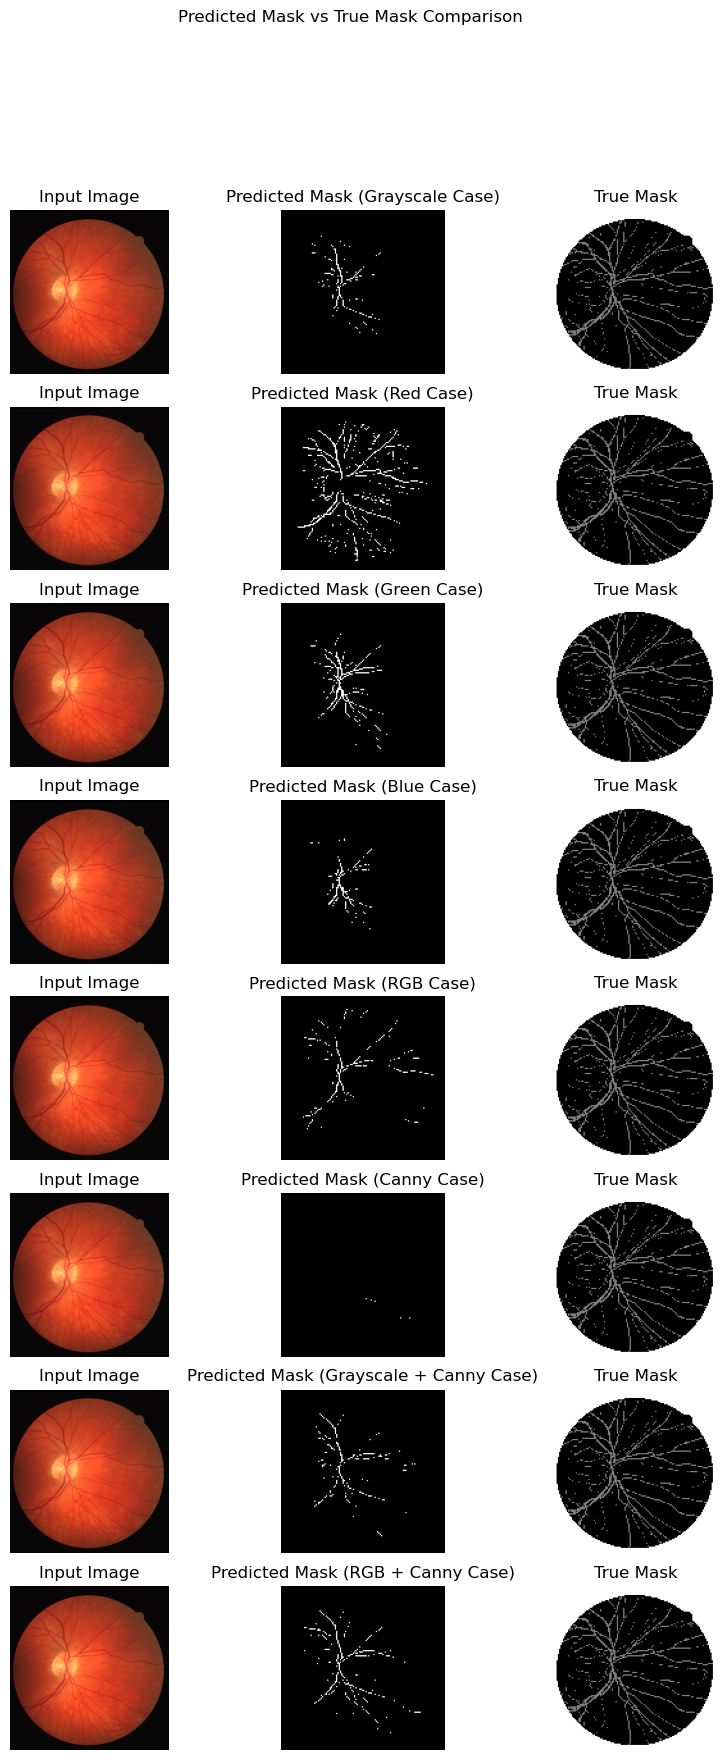

In [ ]:
df = pd.DataFrame(columns=['input','precision','recall','f1_score','accuracy','jaccard'])
example_index = random.sample(range(len(test_index)),1)[0]
true_mask = RetinaRGB(20,img_size,test_images,test_masks,test_manuals).__getitem__(0)[1]
fig, ax = plt.subplots(len(list_case),3,figsize=(10,20))
for index, case in enumerate(list_case):
    model = tf.keras.models.load_model(f"./{case['input']}.h5",compile=False)

    pred = model.predict(case["class_name"](20,img_size,test_images,test_masks,test_manuals).__getitem__(0)[0])
    pred = pred[:,:,:,1] #mencari probabilitas dari kelas 1 (retina)

    pred = np.where(pred>0.5,1,0)

    #input image
    ax[index,0].imshow(Image.open(test_images[example_index]))
    ax[index,0].axis('off')

    #predicted mask
    ax[index,1].imshow(pred[example_index],cmap='gray')
    ax[index,1].axis('off')
    #true mask
    ax[index,2].imshow(true_mask[example_index],cmap='gray')
    ax[index,2].axis('off')

    ax[index,0].set_title("Input Image")
    ax[index,1].set_title(f"Predicted Mask ({case['input']} Case)")
    ax[index,2].set_title(f"True Mask")
    fig.suptitle("Predicted Mask vs True Mask Comparison")



    pred = np.ravel(pred)


    truth = (true_mask == 1.).astype(int)
    print(truth.shape)
    truth = np.ravel(truth)

    df = pd.concat(
        [df,pd.DataFrame([{
            'input': case['input'],
            'precision': precision(pred,truth),
            'recall': recall(pred,truth),
            'f1_score': f1_score(pred,truth),
            'accuracy': accuracy(pred,truth),
            'jaccard': jaccard(pred,truth),
        }])]
    )

In [ ]:
df = df.reset_index(drop=True)
df

,input,precision,recall,f1_score,accuracy,jaccard
0,Grayscale,0.979007,0.120215,0.214135,0.922699,0.119905
1,Red,0.820421,0.270387,0.406728,0.930896,0.255279
2,Green,0.978013,0.241718,0.387632,0.933093,0.240412
3,Blue,0.950310,0.203191,0.334797,0.929263,0.201055
4,RGB,0.986939,0.205316,0.339918,0.930142,0.204759
5,Canny,0.576613,0.004981,0.009877,0.912509,0.004963
6,Grayscale + Canny,0.946655,0.111889,0.200125,0.921643,0.111188
7,RGB + Canny,0.980661,0.254363,0.403950,0.934238,0.253093


Selain itu, kita coba bandingkan dengan hasil yang terjadi apabila dataset tidak diaugmentasi. Kode yang digunakan sama seperti sebelumnya, hanya saja datasetnya tidak memasukkan file hasil augmentasi.

In [ ]:

epochs = 400 #10 kali lipat karena tidak diberi multiplicator augmentation
num_classes = 3
img_size = (128, 128)
batch_size = 1

In [ ]:

#example of item : './Data/training/images/21_training.tif'
training_index = [item.split("_")[0] for item in os.listdir("./Data/training/images")]

training_images = [f"./Data/training/images/{idx}_training.tif" for idx in training_index]
training_manuals= [f"./Data/training/1st_manual/{idx}_manual1.gif" for idx in training_index]
training_masks= [f"./Data/training/mask/{idx}_training_mask.gif" for idx in training_index]

test_index = [item.split("_")[0] for item in os.listdir("./Data/test/images")]

test_images = [f"./Data/test/images/{idx}_test.tif" for idx in test_index]
test_manuals= [f"./Data/test/1st_manual/{idx}_manual1.gif" for idx in test_index]
test_masks= [f"./Data/test/mask/{idx}_test_mask.gif" for idx in test_index]

In [ ]:
history_dict_list = []
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0002, restore_best_weights=True)
for case in list_case:
    print(f"Training with {case['input']} input")
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(1e-4)
    losses = tf.keras.losses.BinaryCrossentropy() if num_classes==1 else tf.keras.losses.SparseCategoricalCrossentropy()
    model = make_unet(img_size, num_classes, input_channels=case['input_channels'])
    model.compile(optimizer=optimizer,loss=losses,metrics=[ 'accuracy'])
    train_gen = case['class_name'](batch_size,img_size,training_images,training_masks,training_manuals)
    test_gen = case['class_name'](batch_size,img_size,test_images,test_masks,test_manuals)
    history = model.fit(train_gen,epochs=epochs,validation_data=test_gen)
    history_dict_list.append({**case, "history": history.history, "total_params":model.count_params()})
    #save model
    model.save(f"./non_augmented_{case['input']}.h5")


Training with Grayscale input
Epoch 1/400
20/20 [==============================] - 7s 34ms/step - loss: 1.3418 - accuracy: 0.3016 - val_loss: 0.9189 - val_accuracy: 0.6133
Epoch 2/400
20/20 [==============================] - 0s 21ms/step - loss: 1.0451 - accuracy: 0.5378 - val_loss: 0.8511 - val_accuracy: 0.8533
Epoch 3/400
20/20 [==============================] - 0s 20ms/step - loss: 0.7984 - accuracy: 0.7527 - val_loss: 0.8364 - val_accuracy: 0.8685
Epoch 4/400
20/20 [==============================] - 0s 21ms/step - loss: 0.6013 - accuracy: 0.8465 - val_loss: 0.8624 - val_accuracy: 0.8731
Epoch 5/400
20/20 [==============================] - 0s 19ms/step - loss: 0.5024 - accuracy: 0.8785 - val_loss: 0.9188 - val_accuracy: 0.8112
Epoch 6/400
20/20 [==============================] - 0s 20ms/step - loss: 0.4492 - accuracy: 0.8903 - val_loss: 0.9486 - val_accuracy: 0.6227
Epoch 7/400
20/20 [==============================] - 0s 20ms/step - loss: 0.4181 - accuracy: 0.8929 - val_loss: 0.9456

In [ ]:
pd_history = pd.DataFrame(columns=['input','total_params','loss','val_loss','accuracy','val_accuracy'])
for history_dict in history_dict_list:
    pd_history = pd.concat(
        [
            pd_history,
            pd.DataFrame(
                [{
                    'input': history_dict['input'],
                    'total_params': history_dict['total_params'],
                    'loss': history_dict['history']['loss'][-1],
                    'val_loss': history_dict['history']['val_loss'][-1],
                    'accuracy': history_dict['history']['accuracy'][-1],
                    'val_accuracy': history_dict['history']['val_accuracy'][-1],
                }],
            )
        ]
    )
pd_history = pd_history.reset_index(drop=True)
pd_history

,input,total_params,loss,val_loss,accuracy,val_accuracy
0,Grayscale,8635875,0.009072,0.282867,0.996866,0.944348
1,Red,8635875,0.014171,0.409924,0.994928,0.914215
2,Green,8635875,0.009412,0.292133,0.996869,0.942075
3,Blue,8635875,0.012189,0.413873,0.995703,0.916956
4,RGB,8636451,0.010093,0.300128,0.996558,0.941772
5,Canny,8635875,0.024384,0.449219,0.990918,0.865903
6,Grayscale + Canny,8636163,0.010915,0.331775,0.996170,0.928616
7,RGB + Canny,8636739,0.009446,0.303589,0.996744,0.942831


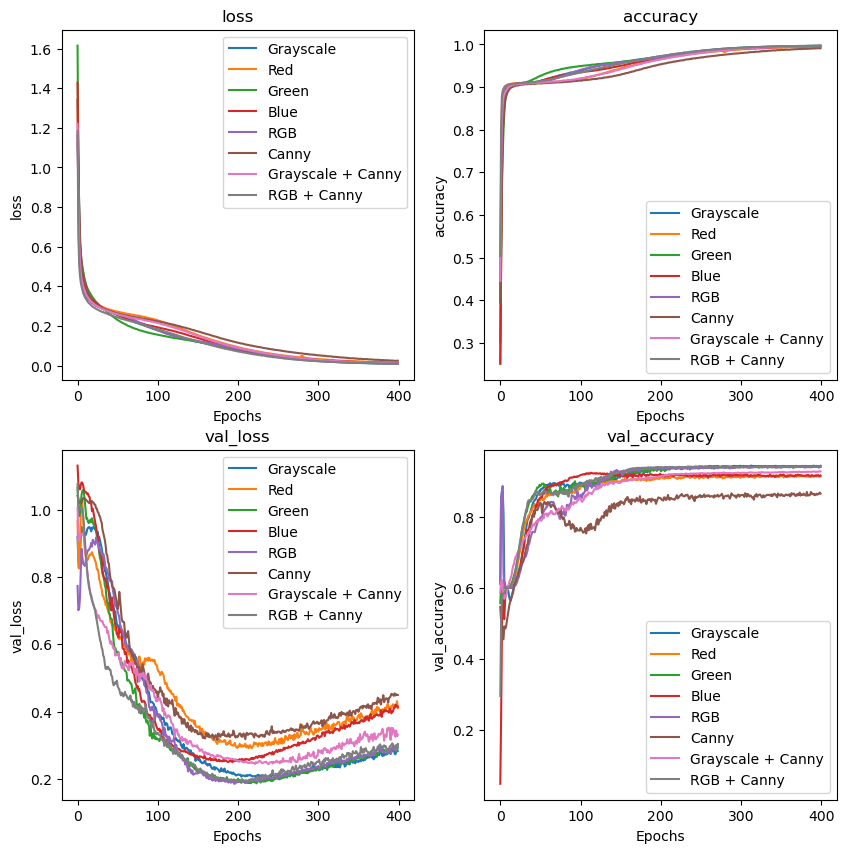

In [ ]:
list_of_metrics = ['loss','accuracy','val_loss','val_accuracy']
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i, metric in enumerate(list_of_metrics):

    for history_dict in history_dict_list:
        ax[i//2,i%2].plot(history_dict['history'][metric])
        ax[i//2,i%2].set_title(metric)
        ax[i//2,i%2].set_xlabel('Epochs')
        ax[i//2,i%2].set_ylabel(metric)
        ax[i//2,i%2].legend([history_dict['input'] for history_dict in history_dict_list])


In [ ]:
np.unique(RetinaRGB(20,img_size,test_images,test_masks,test_manuals).__getitem__(0)[1])

array([0., 1., 2.])

1/1 [==============================] - 0s 215ms/step
(20, 128, 128)
1/1 [==============================] - 0s 203ms/step
(20, 128, 128)
1/1 [==============================] - 0s 197ms/step
(20, 128, 128)
1/1 [==============================] - 0s 190ms/step
(20, 128, 128)
1/1 [==============================] - 0s 191ms/step
(20, 128, 128)
1/1 [==============================] - 0s 192ms/step
(20, 128, 128)
1/1 [==============================] - 0s 188ms/step
(20, 128, 128)
1/1 [==============================] - 0s 185ms/step
(20, 128, 128)


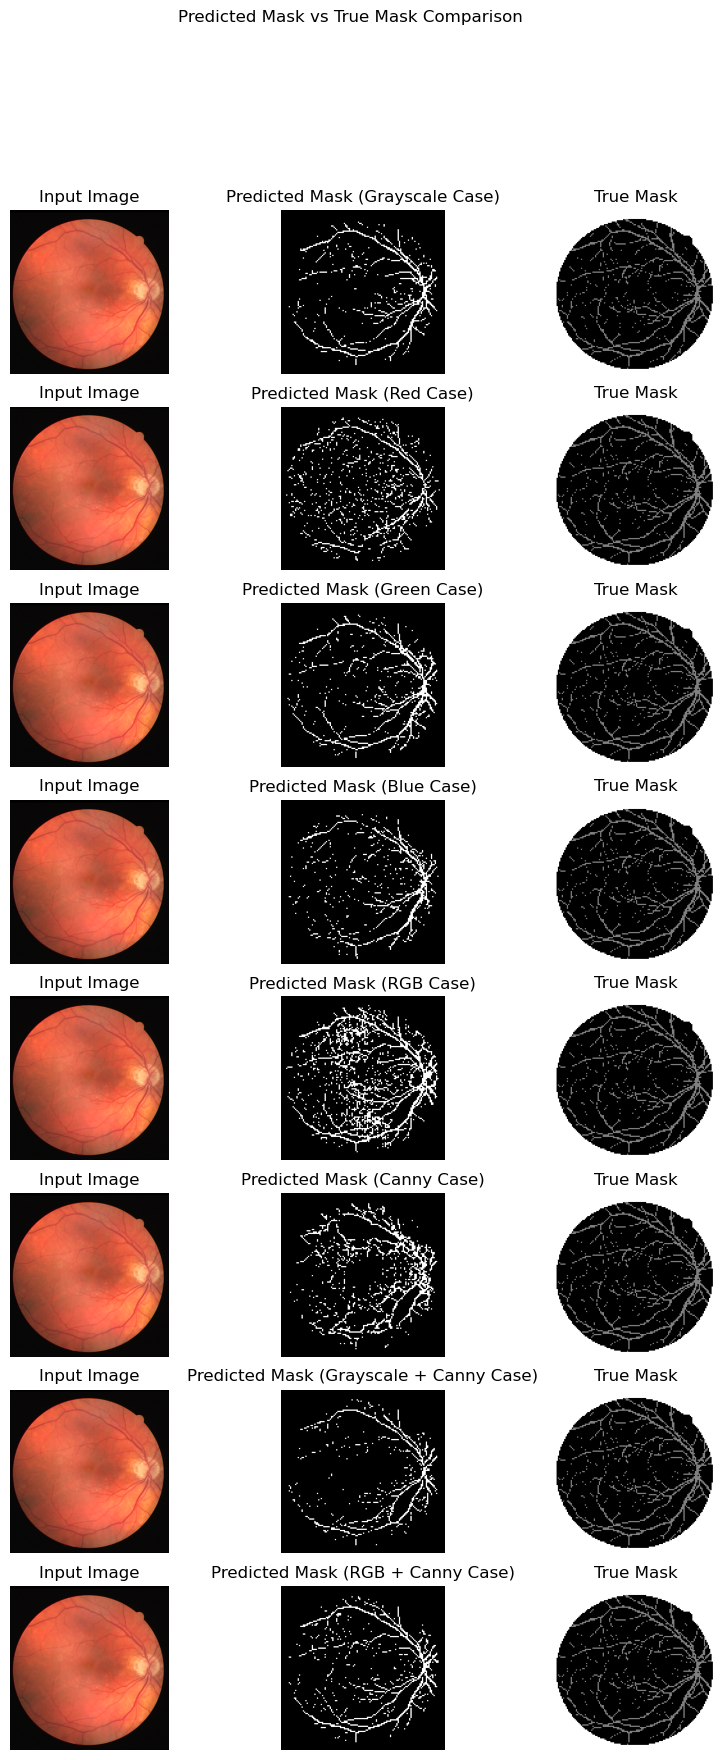

In [ ]:
df = pd.DataFrame(columns=['input','precision','recall','f1_score','accuracy','jaccard'])
example_index = random.sample(range(len(test_index)),1)[0]
true_mask = RetinaRGB(20,img_size,test_images,test_masks,test_manuals).__getitem__(0)[1]
fig, ax = plt.subplots(len(list_case),3,figsize=(10,20))
for index, case in enumerate(list_case):
    model = tf.keras.models.load_model(f"./non_augmented_{case['input']}.h5",compile=False)

    pred = model.predict(case["class_name"](20,img_size,test_images,test_masks,test_manuals).__getitem__(0)[0])
    pred = pred[:,:,:,1]

    pred = np.where(pred>0.5,1,0)

    #input image
    ax[index,0].imshow(Image.open(test_images[example_index]))
    ax[index,0].axis('off')

    #predicted mask
    ax[index,1].imshow(pred[example_index],cmap='gray')
    ax[index,1].axis('off')
    #true mask
    ax[index,2].imshow(true_mask[example_index],cmap='gray')
    ax[index,2].axis('off')

    ax[index,0].set_title("Input Image")
    ax[index,1].set_title(f"Predicted Mask ({case['input']} Case)")
    ax[index,2].set_title(f"True Mask")
    fig.suptitle("Predicted Mask vs True Mask Comparison")



    pred = np.ravel(pred)


    truth = (true_mask == 1.).astype(int)

    print(truth.shape)
    truth = np.ravel(truth)

    df = pd.concat(
        [df,pd.DataFrame([{
            'input': case['input'],
            'precision': precision(pred,truth),
            'recall': recall(pred,truth),
            'f1_score': f1_score(pred,truth),
            'accuracy': accuracy(pred,truth),
            'jaccard': jaccard(pred,truth),
        }])]
    )

In [ ]:
df = df.reset_index(drop=True)
df
#visualize the performancetable using seaborn


,input,precision,recall,f1_score,accuracy,jaccard
0,Grayscale,0.767439,0.579475,0.660342,0.947775,0.492918
1,Red,0.536708,0.414080,0.467486,0.917355,0.305045
2,Green,0.720627,0.618107,0.665442,0.945551,0.498623
3,Blue,0.566410,0.423520,0.484653,0.921094,0.319830
4,RGB,0.741758,0.572125,0.645991,0.945065,0.477095
5,Canny,0.298386,0.338663,0.317251,0.872299,0.188531
6,Grayscale + Canny,0.707390,0.376772,0.491670,0.931747,0.325970
7,RGB + Canny,0.787955,0.523217,0.628860,0.945895,0.458640
